In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from IPython.display import Image

In [2]:
#import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
#from camb import model, initialpower
from astropy.table import Table
#from scipy.misc import derivative

In [3]:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'

TESTING_PRODUCTS_PATH = "/Users/megantabbutt/Cosmology/Cosmology/SNe CrossCorrelations/VerificationTestingProducts/"

TESTING_PRODUCTS_PATH = TESTING_PRODUCTS_PATH + "21_10_20_R03/"

NOTES_PATH = TESTING_PRODUCTS_PATH + 'RunNotes_Theory.txt'

def NotesToWrite(notes):
    NOTES = open(NOTES_PATH, "a")
    NOTES.write(notes)
    NOTES.write("\n \n")
    NOTES.close()

In [4]:
h = .6774

# a = 1/(1+z)
def hubble_z(z): # Flat universe: omega_k = 0
    hubble_0 = 67.74 # km/sec/Mpc
    Omega_m = .3089
    Omega_L = .6911
    H_z = np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_L))
    return H_z

print("hubble (z=2.0): ", hubble_z(2.0))


def chi_z(z_max):
    c = 3.0*(10**5) # km/sec 
    integrand = lambda z: c / hubble_z(z)
    chi_z = scipy.integrate.quad(integrand, 0, z_max)
    return chi_z[0]

print("chi_z(z = 2.0): ", chi_z(2.0))


z_values = np.linspace(0, 2, 100)
chi_values = [chi_z(redShift) for redShift in z_values]
z_chi_interp = InterpolatedUnivariateSpline(chi_values, z_values, k=5)

def z_chi(chi):
    z_val = z_chi_interp(chi)
    return z_val

print("z_chi(chi=100): ", z_chi(100))


z_chi_deriv = z_chi_interp.derivative()
print("z_chi_deriv(chi=100)", z_chi_deriv(100))


hubble (z=2.0):  203.57419733021177
chi_z(z = 2.0):  5316.055934317975
z_chi(chi=100):  0.02269991388964706
z_chi_deriv(chi=100) 0.00022821635586028148


In [ ]:
"""CMASSLOWZTOT_South_Tbl = Table.read('/Users/megantabbutt/CosmologyDataProducts/' 
                                    + 'galaxy_DR12v5_CMASSLOWZTOT_South.fits', format='fits')
del CMASSLOWZTOT_South_Tbl['FRACPSF', 'EXPFLUX', 'DEVFLUX', 'PSFFLUX', 'MODELFLUX', 'FIBER2FLUX', 'R_DEV', 'EXTINCTION', 
                           'PSF_FWHM', 'SKYFLUX', 'IMAGE_DEPTH', 'TILE', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'ICHUNK', 'RUN', 
                          'IPOLY', 'AIRMASS', 'EB_MINUS_V', 'IMATCH', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_STAR',
                          'WEIGHT_SEEING', 'WEIGHT_SYSTOT', 'COMP', 'PLATE', 'FIBERID', 'MJD', 'FINALN', 'SPECTILE', 'ICOLLIDED', 
                          'INGROUP', 'MULTGROUP', 'ISECT']
CMASSLOWZTOT_DF = CMASSLOWZTOT_South_Tbl.to_pandas()
CMASSLOWZTOT_DF.head(3)"""

In [6]:
# Pull in the data and make into pandas dataframe 
qry_BOSS_Data_SouthAndNorthALL = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"
connBOSS = sqlite3.connect('/Users/megantabbutt/CosmologyDataProducts/' + 'CMASS_and_LOWZ.db')
CMASSLOWZTOT_DF = pd.read_sql(qry_BOSS_Data_SouthAndNorthALL, con=connBOSS)
connBOSS.close()
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


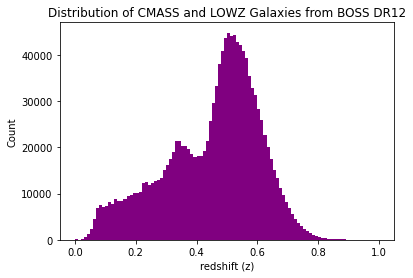

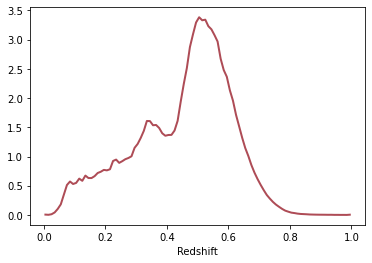

In [17]:
bin_num = 101
bins=np.arange(bin_num)*0.01+0.
c = plt.hist(CMASSLOWZTOT_DF['Z'], bins=bins, color='purple', label = 'Only 0 to 1')
plt.xlabel("redshift (z)")
plt.ylabel("Count")
plt.title("Distribution of CMASS and LOWZ Galaxies from BOSS DR12")
plt.savefig(TESTING_PRODUCTS_PATH+"n dist BOSS")
plt.show()

c[0]
bin_centers = [i + .005 for i in c[1][:-1]]
n_norm = c[0]*100/sum(c[0])

n_interp = interpolate.interp1d(bin_centers, n_norm, kind='cubic', bounds_error=False, fill_value=0.0)  
plt.plot(bin_centers, n_interp(bin_centers), c="#8c000f", alpha=.7, lw=2)
plt.xlabel("Redshift")
plt.show()

In [8]:
def quad_one_dim(integrand, limit_min, limit_max):
    integral = scipy.integrate.quad(integrand, limit_min, limit_max, epsrel=10**-12, epsabs=10**-12, limit=5000)  
    return integral

# n(z) dz/dx integral over x
normalization = quad_one_dim((lambda x: n_interp(z_chi(x)) * z_chi_deriv(x)), chi_z(0.0), chi_z(1.0))
print(normalization)

intgrand = [(n_interp(z_chi(x)) * z_chi_deriv(x)) for x in np.linspace(chi_z(0.0), chi_z(1.0), 100)]

(0.9999324758605875, 3.7209467380798595e-09)


<ipython-input-8-7300af9b0054>:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scipy.integrate.quad(integrand, limit_min, limit_max, epsrel=10**-12, epsabs=10**-12, limit=5000)


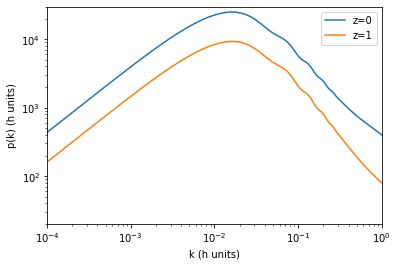

In [9]:
pkall=np.genfromtxt('/Users/megantabbutt/CosmologyDataProducts/pk_none_z0-7_k200cosmosis_kmax100_2019.txt')
newpk=np.reshape(pkall,((701,200)))
klist=np.genfromtxt('/Users/megantabbutt/CosmologyDataProducts/k_h_planck2015ext.txt')
kmin=np.min(klist)
kmax=np.max(klist)
zlist=np.arange(701)*0.01
Pk = sp.interpolate.RectBivariateSpline(zlist,klist,newpk,kx=5,ky=5)

def newPk3(k,z):
    result=Pk(z,k)
    return result

plt.plot(klist,newpk[0],label='z=0')
plt.plot(klist,newpk[100],label='z=1')
plt.xlabel('k (h units)')
plt.ylabel('p(k) (h units)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-4,1)
plt.ylim(2*10,3*10**4)
plt.legend()
plt.show()

In [10]:
def j0(arg):
    return scipy.special.jv(0, arg)

def g2(chi):
    nn = (n_interp(z_chi(chi)) * z_chi_deriv(chi))
    return nn

def powerChi_ROSS(chi, theta):
    h=0.6774
    integrad = lambda k: k * ((1.0/h)**3)*newPk3(k/h, z_chi(chi))[0]*j0(k*chi*theta)
    powint = scipy.integrate.quad(integrad, kmin, kmax, epsrel=10**-4, epsabs=10**-4, limit=500)
    return powint[0]/(2*np.pi)

def ggtheta_ROSS_Pk(theta):
    chi_min = chi_z(0.01)
    chi_max = chi_z(0.9)
    b1=1
    b2=1
    h = .6774
    integrand = lambda chi: (g2(chi)**2) * powerChi_ROSS(chi, theta) * b1 * b2
    result = scipy.integrate.quad(integrand, chi_min, chi_max, epsrel=10**-4, epsabs=10**-4, limit=500)
    return result[0]

In [12]:
kmin = .0001*h
kmax = 100.0*h

theta_array=[0.02,0.06,0.1,0.3,0.5,0.7,1.0]

"""gg_values_Correct = []
for theta in theta_array:
    gg_val = ggtheta_ROSS_Pk(theta*np.pi/180.)
    print(theta, "     ", gg_val)
    gg_values_Correct.append(gg_val)"""
    
gg_values_Correct_south = [0.06839739914235775, 0.02701939910668126, 0.01769078860342759, 0.007646486474742924, 
                     0.0047334619598246395, 0.0032438738334146814, 0.002027372983696616]

gg_values_Correct = [0.06931393625734658, 0.027162241462816875, 0.017858659370836926, 0.0077738649458222045, 
                    0.004785354351079529, 0.0032579407809214516, 0.0020163689649998636]

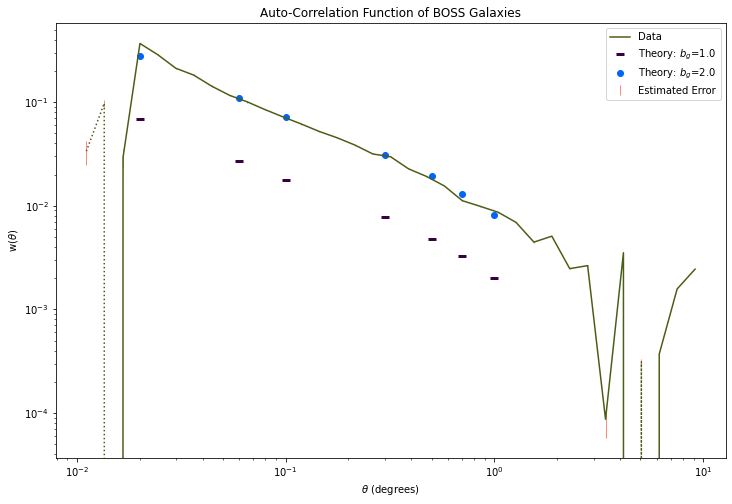

In [18]:
PS_Data = pd.read_csv(TESTING_PRODUCTS_PATH + 'BOSS_AutoCorr_Plot_Results_df.csv', index_col=0)
gg_values_Correct_bias_fixed = [i*(2.0**2) for i in gg_values_Correct]

r_PS = np.array(PS_Data['r'])
xi_PS = np.array(PS_Data['xi'])
sig_PS = np.array(PS_Data['sig'])

plt.figure(figsize=(12, 8))

plt.plot(r_PS, xi_PS, color='#4b5d16', label="Data")
plt.plot(r_PS, -xi_PS, color='#4b5d16', ls=':')

plt.errorbar(r_PS[xi_PS>0], xi_PS[xi_PS>0], yerr=sig_PS[xi_PS>0], color='#fc5a50', lw=1, alpha=.7, ls='')
plt.errorbar(r_PS[xi_PS<0], -xi_PS[xi_PS<0], yerr=sig_PS[xi_PS<0], color='#fc5a50', lw=1, alpha=.7, ls='', label="Estimated Error")

plt.scatter(theta_array, gg_values_Correct, color='#36013f', marker='_', s=60, linewidths=3, label="Theory: $b_g$=1.0")
plt.scatter(theta_array, gg_values_Correct_bias_fixed, color='#0165fc', marker='o', label="Theory: $b_g$=2.0")

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'w($\theta$)')
plt.legend(loc='upper right')
#plt.ylim([.001, .5])
plt.title("Auto-Correlation Function of BOSS Galaxies")
plt.savefig(TESTING_PRODUCTS_PATH + "Auto-Correlation Function of BOSS", facecolor='white')
plt.show()

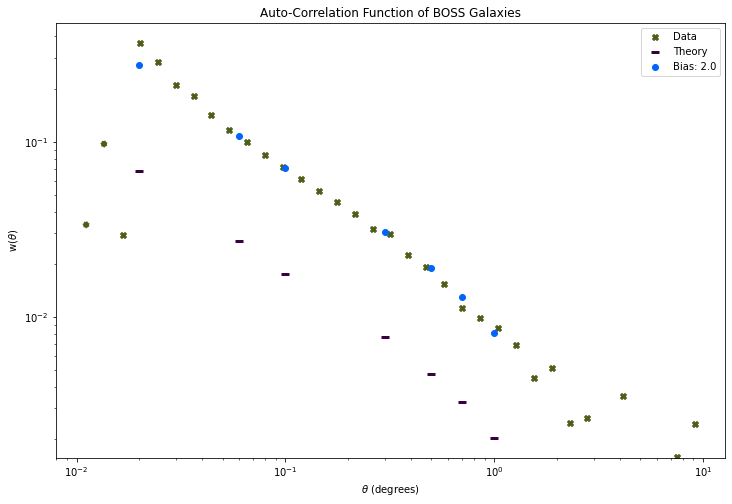

In [14]:
PS_Data = pd.read_csv(TESTING_PRODUCTS_PATH + 'BOSS_AutoCorr_Plot_Results_df.csv', index_col=0)
gg_values_Correct_bias_fixed = [i*(2.0**2) for i in gg_values_Correct]

r_PS = np.array(PS_Data['r'])
xi_PS = np.array(PS_Data['xi'])

plt.figure(figsize=(12, 8))

plt.scatter(r_PS, xi_PS, color='#4b5d16', marker='X', label="Data")
plt.scatter(r_PS, -xi_PS, color='#4b5d16', ls=':')

plt.scatter(theta_array, gg_values_Correct, color='#36013f', marker='_', s=60, linewidths=3, label="Theory")
plt.scatter(theta_array, gg_values_Correct_bias_fixed, color='#0165fc', marker='o', label="Bias: 2.0")

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'w($\theta$)')
plt.legend(loc='upper right')
#plt.ylim([.001, .5])
plt.title("Auto-Correlation Function of BOSS Galaxies")
plt.savefig(TESTING_PRODUCTS_PATH + "Auto-Correlation Function of BOSS V2", facecolor='white')
plt.show()